In [214]:
%load_ext autoreload
%autoreload 2
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import *
from penalties import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
# Parse SHAPE files into dicts with seqs and scores
shape_data = {}
rdat_files = sorted(['SRP_test/'+f for f in os.listdir('SRP_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('SRP_test/SRPECLI_').strip('.rdat.txt')] = parse_rdat(r)

ref_name = list(shape_data.keys())[0]

shape_data['mean_BZCN'] = {}
shape_data['mean_DMS'] = {}
for l in shape_data[ref_name].keys():
    shape_data['mean_BZCN'][l] = {
        'seq' : shape_data[ref_name][l]['seq'],
        'react' : np.mean(np.array([shape_data['BZCN_0001'][l]['react'],
                                    shape_data['BZCN_0002'][l]['react'],
                                    shape_data['BZCN_0003'][l]['react'],
                                    shape_data['BZCN_0004'][l]['react']]), axis=0)
    }
    shape_data['mean_DMS'][l] = {
        'seq' : shape_data[ref_name][l]['seq'],
        'react' : np.mean(np.array([shape_data['DMS_0001'][l]['react'],
                                    shape_data['DMS_0002'][l]['react'],
                                    shape_data['DMS_0003'][l]['react']]), axis=0)
    }

md = RNA.md()
md.temperature = 37 #Both transcription and modification was done at 37

In [255]:
# Create reference datasets for the best of each algorithm
compute_data = {}



name_func_map = {'no_constraint' : no_constraint, 
                 'mfe_const' : constant_penalty, 
                 'mfe_seq_dep' : sequence_dependent_penalty,
                 #'hierarchical' : hierarchical_fold, 
                 'ensemble_const' : constant_ensemble_penalty, 
                 'ensemble_seq_dep' : sequence_dependent_ensemble_penalty
                 }

name_pen_map = { 'no_constraint' : 0, 
                 'mfe_const' : 5, 
                 'mfe_seq_dep' : 0.034,
                 #'hierarchical' : 10, 
                 'ensemble_const' : 20, 
                 'ensemble_seq_dep' : 0.034
                 }

for dn in name_func_map.keys():
    compute_data[dn] = {
        'func' : name_func_map[dn],
        'pen' : name_pen_map[dn]
    }
    for l in shape_data[ref_name]:
        compute_data[dn][l] = {
            'seq' : shape_data[ref_name][l]['seq'],
        }

In [256]:
# Calculate folding pathways for each SHAPE dataset
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        d[length]['mfe'] = shape_constraint(subseq, reactivities, md)[0]


Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0004
Working on DMS_0001
Working on DMS_0002
Working on DMS_0003
Working on mean_BZCN
Working on mean_DMS


In [257]:
# Calculate folding pathways for each kinetic algorithm
for n, d in compute_data.items():
    print(f'Working on {n}')
    if 'ensemble' in n:
        last = []
    else:
        last = ''
        
    for length in d.keys():
        if type(length) != int: # 'func' and 'pen' are also in here
            continue
        subseq = d[length]['seq']
        last = d['func'](subseq, d['pen'], last, md)
        if 'ensemble' in n: # subopt returns a list of subopt objects
            d[length]['mfe'] = last[0].structure
        else: # mfe returns a tuple where 0 is mfe and 1 is energy
            d[length]['mfe'] = last[0]
        

Working on no_constraint
Working on mfe_const
Working on mfe_seq_dep
Working on ensemble_const
Working on ensemble_seq_dep


In [258]:
# also try drtransformer
print("Working on drtransformer")
name = 'SRP_test/SRP_drt.log'

compute_data['drtransformer'] = parse_drt_file(name, shape_data[ref_name])

Working on drtransformer


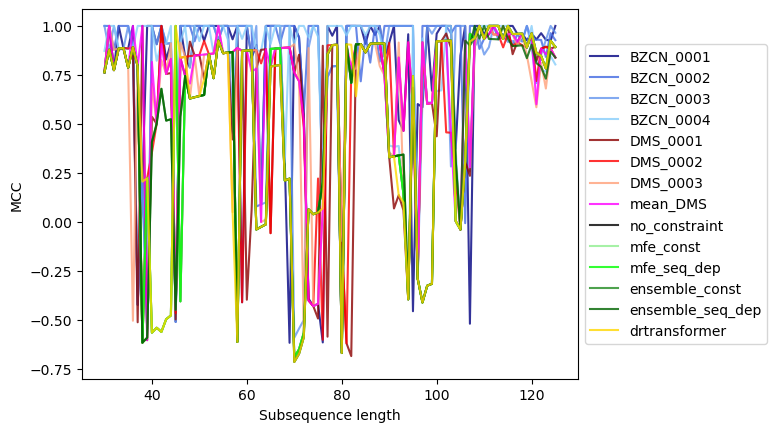

In [263]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0004' : 'lightskyblue', 
        'mean_BZCN' : 'cyan',
        'DMS_0001' : 'darkred', 
        'DMS_0002' : 'red', 
        'DMS_0003' : 'lightsalmon', 
        'mean_DMS' : 'magenta',
        'mfe_const' : 'lightgreen', 
        'mfe_seq_dep' : 'lime',
        'ensemble_const' : 'forestgreen',
        'ensemble_seq_dep' : 'darkgreen',
        'drtransformer' : 'gold',
        'no_constraint' : 'black'}

reference = 'mean_BZCN' #0002 is the most similar to the other BZCNs

fig, ax = plt.subplots()
for n, d in [it for it in list(shape_data.items()) if it[0] != reference]: 
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data[reference][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

for n, d in compute_data.items(): 
    x = [l for l in list(d.keys()) if type(l) == int] # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data[reference][l]['mfe'])) for l in x]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

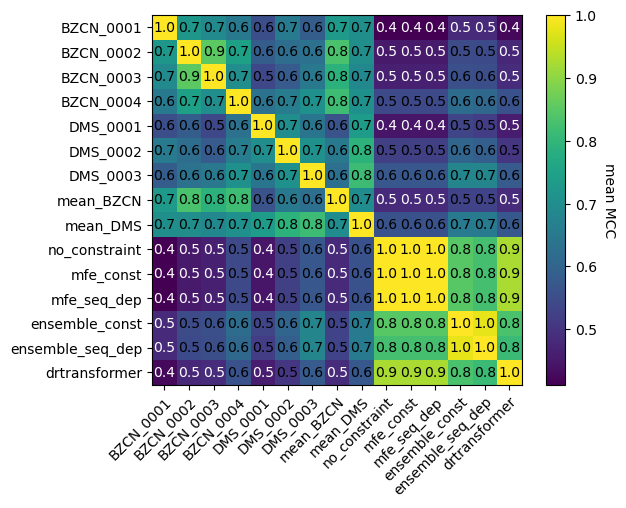

In [260]:
# plot mean MCC between different methods
fig, ax = plt.subplots()

# SHAPE vs SHAPE
corr = np.ones((len(shape_data.keys())+len(compute_data.keys()), len(shape_data.keys())+len(compute_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c
        
# computed vs computed
for i, (n1, d1) in enumerate(compute_data.items()):
    for j, (n2, d2) in enumerate(compute_data.items()):
        if i <= j:
            continue
        offset = len(shape_data.keys())
        lengths = [l for l in list(d1.keys()) if type(l) == int]
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in lengths])
        corr[i+offset, j+offset] = c
        corr[j+offset, i+offset] = c

# SHAPE vs computed
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(compute_data.items()):
        offset = len(shape_data.keys())
        lengths = [l for l in list(d1.keys()) if type(l) == int]
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in lengths])
        corr[i, j+offset] = c
        corr[j+offset, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())+len(compute_data.keys())), list(shape_data.keys())+list(compute_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())+len(compute_data.keys())), list(shape_data.keys())+list(compute_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [222]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']
        
        pred_at_pen[p][length] = constant_penalty(subseq, p, last_structure, md)[0]
        
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [223]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [224]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.558	0.607	0.572
10	0.546	0.600	0.561
15	0.546	0.600	0.561
20	0.553	0.608	0.569
25	0.539	0.583	0.552
30	0.490	0.536	0.503
35	0.480	0.533	0.495
40	0.480	0.533	0.495
45	0.480	0.533	0.495
50	0.472	0.524	0.487
55	0.461	0.513	0.476
60	0.427	0.501	0.448
65	0.526	0.601	0.547
70	0.518	0.593	0.540
75	0.510	0.584	0.531
80	0.477	0.557	0.500
85	0.477	0.557	0.500
90	0.467	0.547	0.490
95	0.467	0.547	0.490
100	0.449	0.529	0.472

Best!
bzcn:	penalty=5 MCC=0.558
dms:	penalty=20 MCC=0.608
all:	penalty=5 MCC=0.572


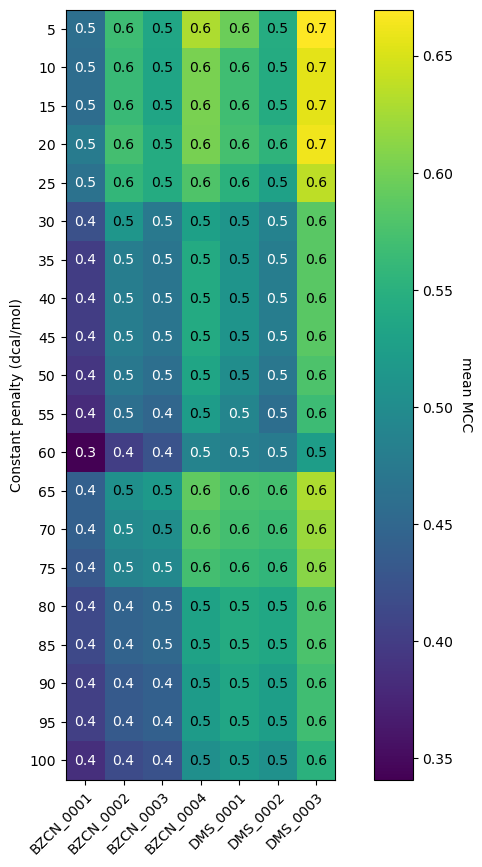

In [225]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [270]:
# Let's try the situation where it's dependent on the base pair broken

#percents = np.arange(0.01, 0.262, 0.012)
percents = np.arange(0.00, 1.05, 0.05)
pred_at_cent = {}
for p in percents:
    #print("Working on percentage = {:.3f}".format(p), end='; ')
    print("Working on percentage = {:.3f}".format(p))
    pred_at_cent[p] = {}
    #p_list = []
    last_structure = ''
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']

        pred_at_cent[p][length] = sequence_dependent_penalty(subseq, p, last_structure, md)[0]
        last_structure = pred_at_cent[p][length]
    
    #print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.000
Working on percentage = 0.050
Working on percentage = 0.100
Working on percentage = 0.150
Working on percentage = 0.200
Working on percentage = 0.250
Working on percentage = 0.300
Working on percentage = 0.350
Working on percentage = 0.400
Working on percentage = 0.450
Working on percentage = 0.500
Working on percentage = 0.550
Working on percentage = 0.600
Working on percentage = 0.650
Working on percentage = 0.700
Working on percentage = 0.750
Working on percentage = 0.800
Working on percentage = 0.850
Working on percentage = 0.900
Working on percentage = 0.950
Working on percentage = 1.000


In [271]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.1].keys())])

In [272]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.000	0.471	0.531	0.493
0.050	0.558	0.616	0.580
0.100	0.475	0.524	0.494
0.150	0.429	0.480	0.448
0.200	0.485	0.536	0.504
0.250	0.476	0.527	0.495
0.300	0.462	0.513	0.481
0.350	0.186	0.232	0.203
0.400	0.184	0.229	0.201
0.450	0.185	0.230	0.202
0.500	0.184	0.229	0.201
0.550	0.153	0.192	0.167
0.600	0.153	0.192	0.167
0.650	0.154	0.193	0.168
0.700	0.154	0.193	0.168
0.750	0.154	0.193	0.168
0.800	0.154	0.193	0.168
0.850	0.154	0.193	0.168
0.900	0.154	0.193	0.168
0.950	0.154	0.193	0.168
1.000	0.154	0.193	0.168

Best!
bzcn:	penalty=0.050 MCC=0.558
dms:	penalty=0.050 MCC=0.616
all:	penalty=0.050 MCC=0.580


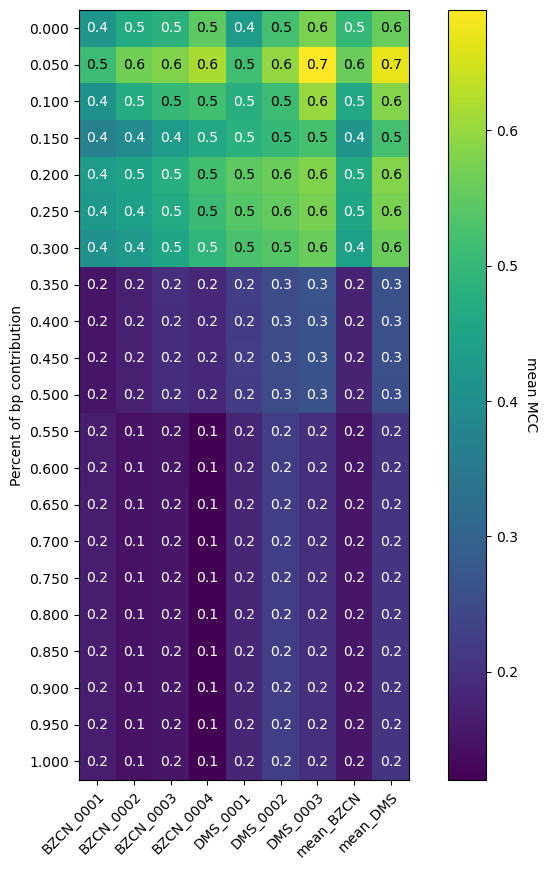

In [273]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()

In [230]:
#p = .5
#last_structure = ''
#for length in shape_data[ref_name].keys():
#    subseq = shape_data[ref_name][length]['seq']
#    fc = RNA.fold_compound(subseq, md)
#    fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
#    penalty_dict = get_penalties(last_structure, fc_last)
#    step_info = {
#            'last_dict' : dict_dot_bracket(last_structure),
#            'penalty_dict' : penalty_dict,
#            'penalty_percent' : p
#        }
#    fc.sc_add_f(penalize_barriers_seq)
#    fc.sc_add_data(step_info)
#
#    out = fc.mfe()
#
#    last_structure = out[0]
#    print(out)

In [231]:
# Let's see how this compares with hierarchical folding
# The problem here is that I have even less of a 'ground truth' in this case
# This didn't work.
#pred_at_span_pen = {}
#full_seq = shape_data[ref_name][list(shape_data[ref_name].keys())[-1]]['seq']
#
#for p in penalties:
#    print("working on penalty =", p)
#    pred_at_span_pen[p] = {}
#    last_structure = ''
#    for length in shape_data[ref_name].keys():
#        pred_at_span_pen[p][length] = hierarchical_fold(full_seq, p, last_structure, length)[0]
#        last_structure = pred_at_span_pen[p][length]


In [232]:
#span_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
#for i, p in enumerate(penalties):
#    for j, k in enumerate(shape_data.keys()):
#        span_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_span_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_span_pen[5].keys())])

In [233]:
#best  = {
#    "bzcn" : {"pen" : -1, "mcc" : -1},
#    "dms" : {"pen" : -1, "mcc" : -1},
#    "all" : {"pen" : -1, "mcc" : -1}
#}
#print(f"Penalty\tBzCN\tDMS\tAll")
#for i, row in enumerate(span_penalty_sweep):
#    bzcn = np.mean(row[0:5])
#    dms = np.mean(row[5:8])
#    all = np.mean(row[0:8])
#    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
#    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
#    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
#    print(f"{penalties[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")
#
#print()
#print("Best!")
#for k, v in best.items():
#    print(f"{k}:\tpenalty={penalties[v['pen']]:.3f} MCC={v['mcc']:.3f}")

In [234]:
#fig, ax = plt.subplots(figsize=(10, 10))
#
#im = ax.imshow(span_penalty_sweep, origin='upper')
#ax.set_yticks(np.arange(len(penalties)), penalties)
#ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
#ax.set_ylabel('Constant penalty (dcal/mol)')
#
#cbar = ax.figure.colorbar(im, ax=ax)
#cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")
#
## annotate heatmap
#threshold = im.norm(span_penalty_sweep.max())/2
#kw = dict(horizontalalignment="center",
#          verticalalignment="center")
#textcolors = ["white", "black"]
#for i in range(len(penalty_sweep)):
#    for j in range(len(shape_data.keys())):
#        kw.update(color=textcolors[int(span_penalty_sweep[i, j] > threshold)])
#        text = im.axes.text(j, i, "{:.1f}".format(span_penalty_sweep[i, j]), **kw)

In [235]:
# Penalties based on probabilities of folding a given base pair
pred_at_ens_pen = {}

for p in penalties:
    print("working on penalty =", p)
    pred_at_ens_pen[p] = {}
    last_ensemble = []
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']
        
        last_ensemble = constant_ensemble_penalty(subseq, p, last_ensemble, md)
        pred_at_ens_pen[p][length] = last_ensemble[0].structure

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [236]:
ens_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        ens_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_ens_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_ens_pen[5].keys())])

In [237]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(ens_penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5.000	0.479	0.513	0.489
10.000	0.487	0.521	0.497
15.000	0.515	0.560	0.528
20.000	0.556	0.604	0.569
25.000	0.539	0.586	0.553
30.000	0.546	0.595	0.560
35.000	0.525	0.572	0.539
40.000	0.520	0.560	0.531
45.000	0.520	0.561	0.532
50.000	0.520	0.561	0.532
55.000	0.510	0.550	0.521
60.000	0.510	0.550	0.521
65.000	0.514	0.552	0.525
70.000	0.514	0.551	0.524
75.000	0.514	0.551	0.524
80.000	0.514	0.550	0.524
85.000	0.504	0.539	0.514
90.000	0.504	0.539	0.514
95.000	0.494	0.526	0.503
100.000	0.493	0.526	0.503

Best!
bzcn:	penalty=20.000 MCC=0.556
dms:	penalty=20.000 MCC=0.604
all:	penalty=20.000 MCC=0.569


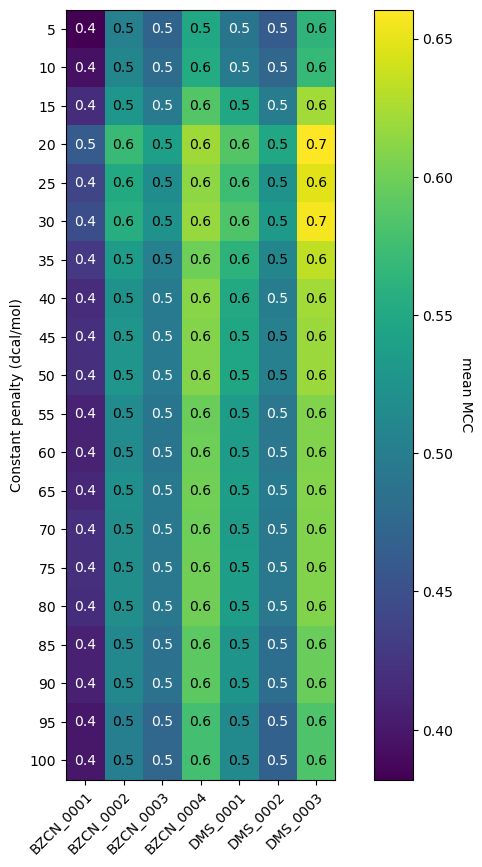

In [238]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ens_penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(ens_penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(ens_penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(ens_penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(ens_penalty_sweep[i, j]), **kw)

In [239]:
# Check how good of an estimate subopt is vs the whole partition function
full_seq = shape_data[ref_name][list(shape_data[ref_name].keys())[-1]]['seq']
mfe_percent = []
e_range = np.arange(50, 1050, 50)
for e in e_range:
    print(f"Working on range={e}")
    e = int(e)
    fc = RNA.fold_compound(full_seq, md)
    competing = fc.subopt(e)
    energies = np.array([c.energy for c in competing])
    energies *= -1 * 1.624
    mfe_percent.append(np.exp(energies[0]) / np.sum(np.exp(energies)))


Working on range=50
Working on range=100
Working on range=150
Working on range=200
Working on range=250
Working on range=300
Working on range=350
Working on range=400
Working on range=450
Working on range=500
Working on range=550
Working on range=600
Working on range=650
Working on range=700
Working on range=750
Working on range=800
Working on range=850
Working on range=900
Working on range=950
Working on range=1000


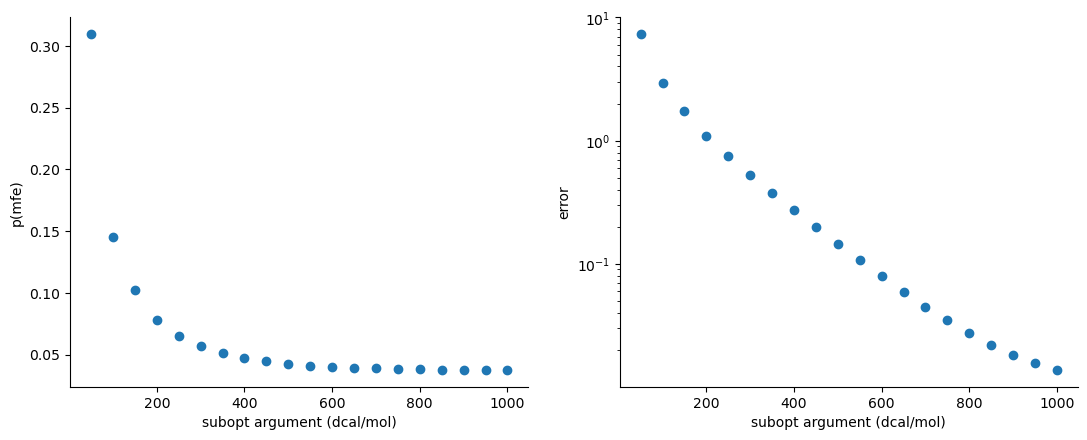

In [240]:
fig, ax = plt.subplots(1, 2, figsize=(13,4.8))
ax[0].scatter(e_range, mfe_percent)
ax[0].set_ylabel('p(mfe)')
ax[0].set_xlabel('subopt argument (dcal/mol)')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

real = 0.0370808

error = [(m - real)/real for m in mfe_percent]
ax[1].scatter(e_range, error)
ax[1].set_ylabel('error')
ax[1].set_yscale('log')
ax[1].set_xlabel('subopt argument (dcal/mol)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.show()

In [241]:
# Penalties based on probabilities of folding a given base pair
pred_at_ens_cent = {}

for p in percents:
    print("Working on percentage = {:.3f}".format(p))
    pred_at_ens_cent[p] = {}
    last_ensemble = []
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']
        
        last_ensemble = sequence_dependent_ensemble_penalty(subseq, p, last_ensemble, md)
        pred_at_ens_cent[p][length] = last_ensemble[0].structure

Working on percentage = 0.010
Working on percentage = 0.022
Working on percentage = 0.034
Working on percentage = 0.046
Working on percentage = 0.058
Working on percentage = 0.070
Working on percentage = 0.082
Working on percentage = 0.094
Working on percentage = 0.106
Working on percentage = 0.118
Working on percentage = 0.130
Working on percentage = 0.142
Working on percentage = 0.154
Working on percentage = 0.166
Working on percentage = 0.178
Working on percentage = 0.190
Working on percentage = 0.202
Working on percentage = 0.214
Working on percentage = 0.226
Working on percentage = 0.238
Working on percentage = 0.250


In [242]:
ens_cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        ens_cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_ens_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_ens_cent[0.01].keys())])

In [243]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(ens_cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.480	0.513	0.489
0.022	0.528	0.573	0.541
0.034	0.549	0.603	0.564
0.046	0.540	0.593	0.555
0.058	0.530	0.582	0.544
0.070	0.519	0.565	0.532
0.082	0.500	0.536	0.510
0.094	0.510	0.551	0.522
0.106	0.525	0.575	0.539
0.118	0.530	0.580	0.544
0.130	0.530	0.580	0.544
0.142	0.512	0.560	0.526
0.154	0.512	0.560	0.526
0.166	0.503	0.550	0.516
0.178	0.500	0.550	0.514
0.190	0.480	0.533	0.495
0.202	0.459	0.513	0.474
0.214	0.442	0.512	0.462
0.226	0.419	0.490	0.439
0.238	0.407	0.479	0.427
0.250	0.404	0.479	0.425

Best!
bzcn:	penalty=0.034 MCC=0.549
dms:	penalty=0.034 MCC=0.603
all:	penalty=0.034 MCC=0.564


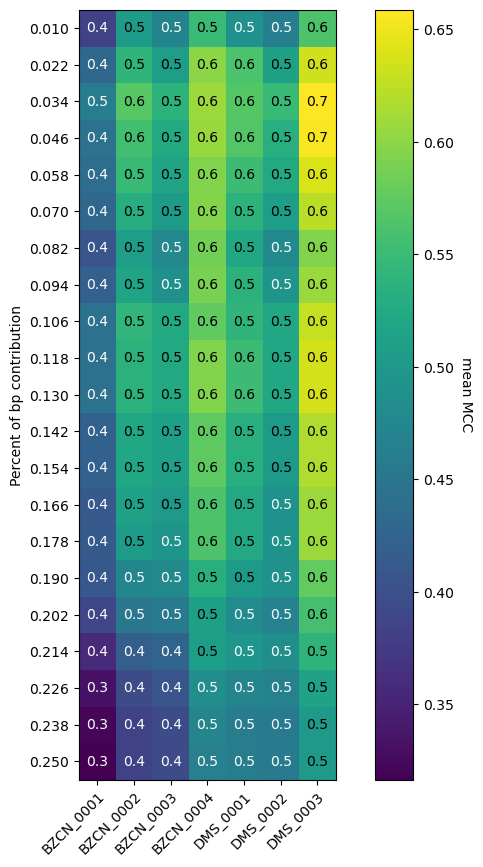

In [244]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ens_cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(ens_cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(ens_cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(ens_cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(ens_cent_sweep[i, j]), **kw)

In [245]:
#TODO do the flouride again
#TODO figure out why the fuck the optimal values for penalties have changed.

# Compare against centroid instead of MFE